<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=160px> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Natural Language Processing</h1>
<h1>Text Representation</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import gzip
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

np.random.seed(123)

import string
import nltk
from nltk.corpus import stopwords  
from nltk.text import TextCollection
from nltk.collocations import BigramCollocationFinder
from nltk.metrics.association import BigramAssocMeasures

import sklearn
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from tqdm import tqdm
tqdm.pandas()

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.12.3

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Git hash: 9c8c00758f3a2fa8e55e08f5aad405a157ca5dd2

numpy     : 1.26.4
watermark : 2.4.3
matplotlib: 3.8.0
sklearn   : 1.5.2
pandas    : 2.2.3
nltk      : 3.8.1



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')

# Tokenization

In [4]:
text = """Mary had a little lamb, little lamb,
    little lamb. 'Mary' had a little lamb
    whose fleece was white as snow.
    And everywhere that Mary went
    Mary went, MARY went. Everywhere
    that mary went,
    The lamb was sure to go"""

The first step is to tokenize the text. NLTK provides us with a convenient tokenizer function we can use. It is also smart enough to be able to handle different languages. __word_tokenize__ splits up our text by word and punctation characters

In [5]:
tokens = nltk.word_tokenize(text, 'english')

In [6]:
pprint(tokens)

['Mary',
 'had',
 'a',
 'little',
 'lamb',
 ',',
 'little',
 'lamb',
 ',',
 'little',
 'lamb',
 '.',
 "'Mary",
 "'",
 'had',
 'a',
 'little',
 'lamb',
 'whose',
 'fleece',
 'was',
 'white',
 'as',
 'snow',
 '.',
 'And',
 'everywhere',
 'that',
 'Mary',
 'went',
 'Mary',
 'went',
 ',',
 'MARY',
 'went',
 '.',
 'Everywhere',
 'that',
 'mary',
 'went',
 ',',
 'The',
 'lamb',
 'was',
 'sure',
 'to',
 'go']


Similarly __sent_tokenize__ splits the text by sentence boundary

In [7]:
sentences = nltk.sent_tokenize(text, 'english')

In [8]:
pprint(sentences)

['Mary had a little lamb, little lamb,\n    little lamb.',
 "'Mary' had a little lamb\n    whose fleece was white as snow.",
 'And everywhere that Mary went\n    Mary went, MARY went.',
 'Everywhere\n    that mary went,\n    The lamb was sure to go']


For now, let's stick with the default word tokenization. You'll note that the default NLTK tokenizer includes apostrophes at the beginning of words and returns all punctuation markings.

In [9]:
print(tokens[5])
print(tokens[12])
print(tokens[13])

,
'Mary
'


To avoid these, we will use the 'WordPunctTokenizer' object, a type of RegExp Tokenizer, instead.

In [10]:
tokens = nltk.tokenize.WordPunctTokenizer().tokenize(text)

This tokenizer naturally treats all punctuation characters are their own individual tokens, which makes it easier to remove the apostrophes

In [11]:
print(tokens[5])
print(tokens[12])
print(tokens[13])
print(tokens[14])

,
'
Mary
'


To simplify, we wrap it into a utility function

In [12]:
def tokenize(text, preserve_case=True):
    punctuation = set(string.punctuation)
    text_words = []
    
    for word in nltk.tokenize.WordPunctTokenizer().tokenize(text):
        # Remove any token that corresponds to a punctuation character
        if word in punctuation:
            continue

        # Are we keeping the original letter case or
        # using lowercase throughout?
        if preserve_case:
            text_words.append(word)
        else:
            text_words.append(word.lower())
        
    return text_words

In [13]:
text_words = tokenize(text, False)

The result is just a list of individual, clean words.

In [14]:
text_words

['mary',
 'had',
 'a',
 'little',
 'lamb',
 'little',
 'lamb',
 'little',
 'lamb',
 'mary',
 'had',
 'a',
 'little',
 'lamb',
 'whose',
 'fleece',
 'was',
 'white',
 'as',
 'snow',
 'and',
 'everywhere',
 'that',
 'mary',
 'went',
 'mary',
 'went',
 'mary',
 'went',
 'everywhere',
 'that',
 'mary',
 'went',
 'the',
 'lamb',
 'was',
 'sure',
 'to',
 'go']

# One-Hot Encoding

We can get a quick one-hot encoded version using pandas:

In [15]:
one_hot = pd.get_dummies(text_words)

Which provides us with a DataFrame where each column corresponds to an individual unique word and each row to a word in our text.

In [16]:
temp = one_hot.astype('str')
temp[temp=='0'] = ""
temp = pd.DataFrame(temp)
temp

,a,and,as,everywhere,fleece,go,had,lamb,little,mary,snow,sure,that,the,to,was,went,white,whose
0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


From here can easily generate a mapping between the words and their numerical id

In [17]:
word_dict = dict(zip(one_hot.columns, np.arange(one_hot.shape[1])))
word_dict

{'a': 0,
 'and': 1,
 'as': 2,
 'everywhere': 3,
 'fleece': 4,
 'go': 5,
 'had': 6,
 'lamb': 7,
 'little': 8,
 'mary': 9,
 'snow': 10,
 'sure': 11,
 'that': 12,
 'the': 13,
 'to': 14,
 'was': 15,
 'went': 16,
 'white': 17,
 'whose': 18}

Allowing us to easily transform from words to ids and back

# Bag of Words

From the one-hot encoded representation we can easily obtain the bag of words version of our document

In [18]:
pd.DataFrame(one_hot.sum(), columns=['Count'])

,Count
a,2
and,1
as,1
everywhere,2
fleece,1
go,1
had,2
lamb,5
little,4
mary,6


A more general representation would be to use a dictionary mapping each word to the number of times it occurs. This has the added advantage of being a dense representation that doesn't waste any space

# Stopwords

NLTK provides stopwords for 23 different languages

In [19]:
os.listdir('/Users/bgoncalves/nltk_data/corpora/stopwords/')

['dutch',
 'catalan',
 'german',
 'slovene',
 'hinglish',
 'hungarian',
 'romanian',
 'kazakh',
 'turkish',
 'russian',
 'README',
 'italian',
 'english',
 'greek',
 'tajik',
 'norwegian',
 'portuguese',
 'hebrew',
 'finnish',
 'danish',
 'french',
 'swedish',
 'azerbaijani',
 'spanish',
 'chinese',
 'indonesian',
 'arabic',
 'nepali',
 'bengali',
 'basque']

And we can easily use them to filter out meaningless words

In [20]:
stop_words = set(stopwords.words('english'))  
  
tokens = tokenize(text)  
  
filtered_sentence = [word if word.lower() not in stop_words else "" for word in tokens]  
  
pd.DataFrame((zip(tokens, filtered_sentence)), columns=['Original', 'Filtered']).set_index('Original')

,Filtered
Original,
Mary,Mary
had,
a,
little,little
lamb,lamb
little,little
lamb,lamb
little,little
lamb,lamb


# TF/IDF

NLTK has the TextCollection object that allows us to easily compute tf-idf scores from a given corpus. We generate a small corpus by splitting our text by sentence

In [21]:
corpus = nltk.sent_tokenize(text)

We have 4 documents in our corpus

In [22]:
len(corpus)

4

NLTK expects the corpus to be tokenized so we do that now

In [23]:
corpus = [tokenize(doc, preserve_case=False) for doc in corpus]

In [24]:
corpus

[['mary', 'had', 'a', 'little', 'lamb', 'little', 'lamb', 'little', 'lamb'],
 ['mary',
  'had',
  'a',
  'little',
  'lamb',
  'whose',
  'fleece',
  'was',
  'white',
  'as',
  'snow'],
 ['and', 'everywhere', 'that', 'mary', 'went', 'mary', 'went', 'mary', 'went'],
 ['everywhere',
  'that',
  'mary',
  'went',
  'the',
  'lamb',
  'was',
  'sure',
  'to',
  'go']]

We initialize the TextCollection object with our corpus

In [25]:
nlp = TextCollection(corpus)

This object provides us with a great deal of functionality, like total frequency counts

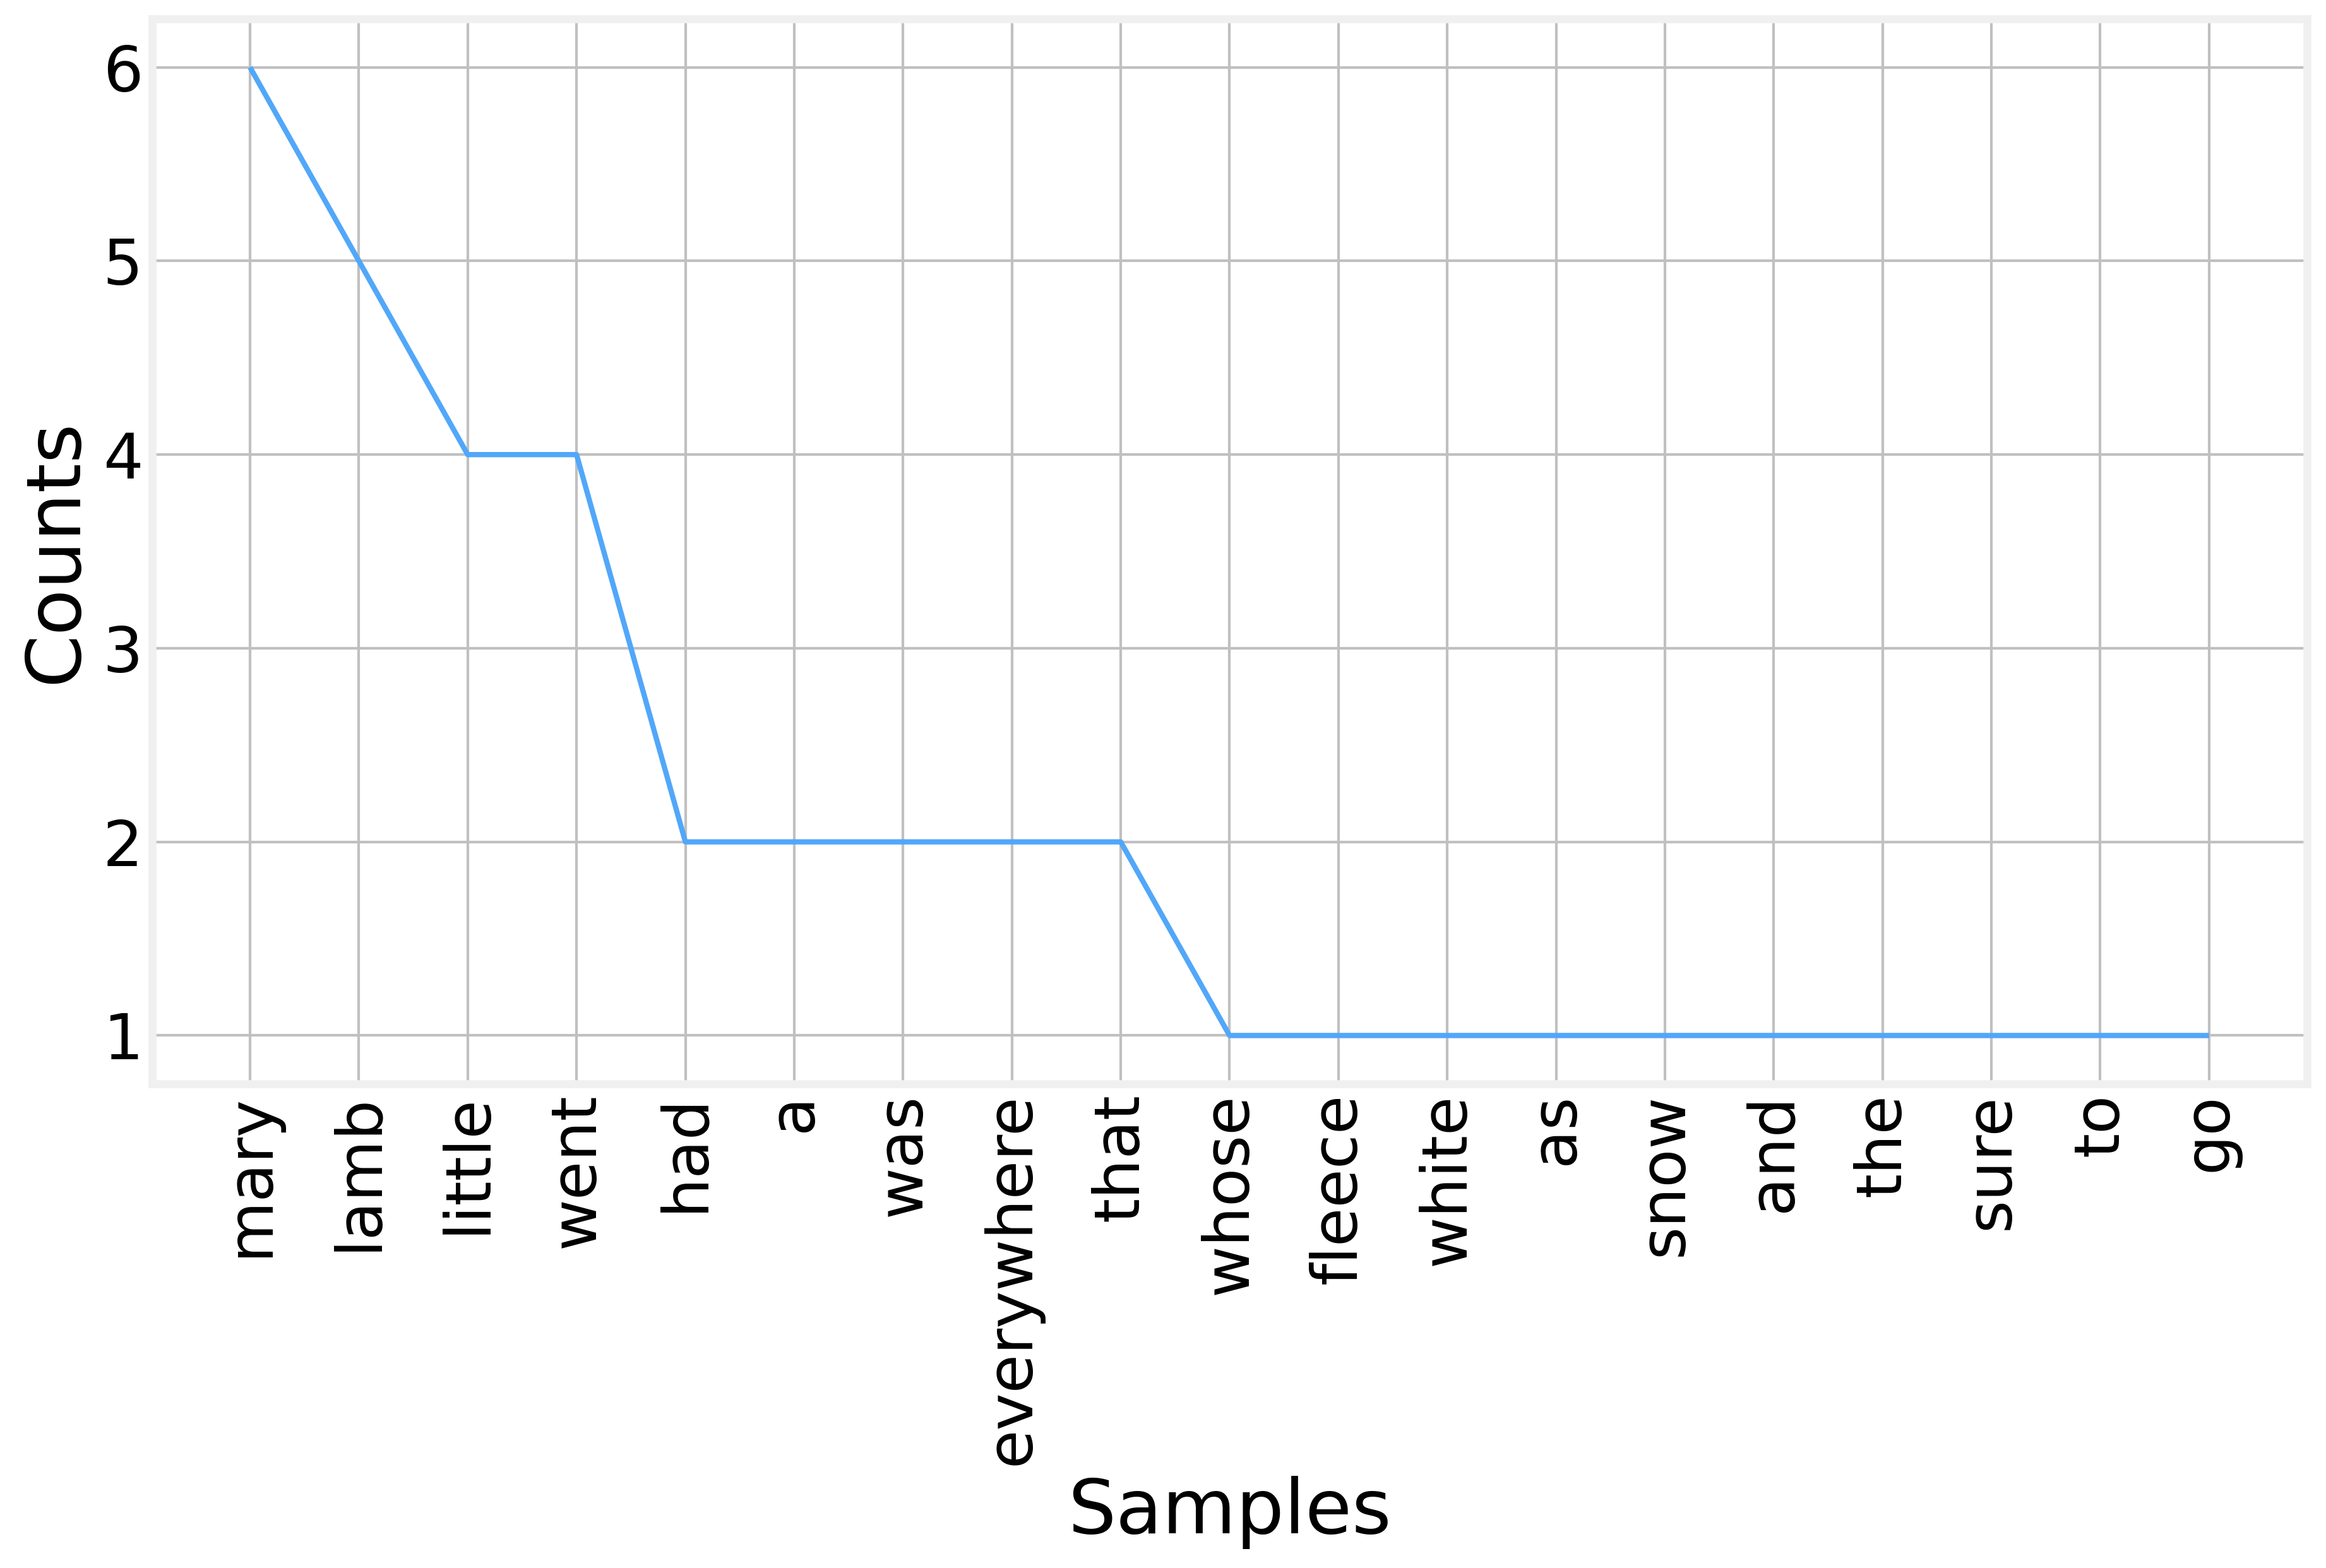

<Axes: xlabel='Samples', ylabel='Counts'>

In [26]:
nlp.plot()

Individual tf/idf scores, etc

In [27]:
nlp.tf_idf('Mary', corpus[3])

0.0

To get the full TF/IDF scores for our corpus, we do

In [28]:
TFIDF = []

for doc in corpus:
    current = {}
    for token in doc:
        current[token] = nlp.tf_idf(token, doc)
        
    TFIDF.append(current)

In [29]:
TFIDF

[{'mary': 0.0,
  'had': 0.07701635339554948,
  'a': 0.07701635339554948,
  'little': 0.23104906018664842,
  'lamb': 0.09589402415059362},
 {'mary': 0.0,
  'had': 0.06301338005090412,
  'a': 0.06301338005090412,
  'little': 0.06301338005090412,
  'lamb': 0.026152915677434625,
  'whose': 0.12602676010180824,
  'fleece': 0.12602676010180824,
  'was': 0.06301338005090412,
  'white': 0.12602676010180824,
  'as': 0.12602676010180824,
  'snow': 0.12602676010180824},
 {'and': 0.15403270679109896,
  'everywhere': 0.07701635339554948,
  'that': 0.07701635339554948,
  'mary': 0.0,
  'went': 0.23104906018664842},
 {'everywhere': 0.06931471805599453,
  'that': 0.06931471805599453,
  'mary': 0.0,
  'went': 0.06931471805599453,
  'the': 0.13862943611198905,
  'lamb': 0.028768207245178087,
  'was': 0.06931471805599453,
  'sure': 0.13862943611198905,
  'to': 0.13862943611198905,
  'go': 0.13862943611198905}]

Here you'll note that nltk is using the version of TF/IDF that sets to zero the weight of words that occur in every document

# N-Grams

In [30]:
def get_ngrams(text, length):
    from nltk.util import ngrams
    
    n_grams = ngrams(tokenize(text), length)
    return [ ' '.join(grams) for grams in n_grams]

In [31]:
get_ngrams(text.lower(), 2)

['mary had',
 'had a',
 'a little',
 'little lamb',
 'lamb little',
 'little lamb',
 'lamb little',
 'little lamb',
 'lamb mary',
 'mary had',
 'had a',
 'a little',
 'little lamb',
 'lamb whose',
 'whose fleece',
 'fleece was',
 'was white',
 'white as',
 'as snow',
 'snow and',
 'and everywhere',
 'everywhere that',
 'that mary',
 'mary went',
 'went mary',
 'mary went',
 'went mary',
 'mary went',
 'went everywhere',
 'everywhere that',
 'that mary',
 'mary went',
 'went the',
 'the lamb',
 'lamb was',
 'was sure',
 'sure to',
 'to go']

# Collocations

In [32]:
bigrams = BigramCollocationFinder.from_words(tokenize(text, False))
scored = bigrams.score_ngrams(BigramAssocMeasures.likelihood_ratio)

In [33]:
scored

[(('little', 'lamb'), 20.789064969512467),
 (('mary', 'went'), 18.154919185356587),
 (('everywhere', 'that'), 15.777294140200038),
 (('had', 'a'), 15.777294140200038),
 (('a', 'little'), 10.232116695720478),
 (('as', 'snow'), 9.301260258907092),
 (('snow', 'and'), 9.301260258907092),
 (('sure', 'to'), 9.301260258907092),
 (('to', 'go'), 9.301260258907092),
 (('white', 'as'), 9.301260258907092),
 (('whose', 'fleece'), 9.301260258907092),
 (('mary', 'had'), 8.139124120662284),
 (('that', 'mary'), 8.139124120662284),
 (('and', 'everywhere'), 6.528671536667327),
 (('fleece', 'was'), 6.528671536667327),
 (('was', 'sure'), 6.528671536667327),
 (('was', 'white'), 6.528671536667327),
 (('went', 'the'), 4.802579101956642),
 (('lamb', 'whose'), 4.297236023525216),
 (('the', 'lamb'), 4.297236023525216),
 (('lamb', 'little'), 3.850143362325084),
 (('went', 'mary'), 3.065215528887738),
 (('went', 'everywhere'), 2.196764352889584),
 (('lamb', 'was'), 1.7502532877068806),
 (('lamb', 'mary'), 0.088193

# Word Embeddings

We start by loading pre-computed Word Embeddings. Here we're using embeddings obtained with GloVE

In [34]:
word_dict = {}
word_list = []
embeddings = np.zeros((400000, 50), dtype='float32')

count = 0
    
with gzip.open('data/glove.6B.50d.txt.gz', 'rt') as fp:
    for line in tqdm(fp):
        fields = line.split()
        word = fields[0]
        word_list.append(word)
        word_dict[word] = count
        embeddings[count] = np.asarray(fields[1:], dtype='float32') 
        count += 1

400000it [00:02, 166905.77it/s]


We can generate a quick visualization of all the vectors

Text(0, 0.5, 'Dimensions')

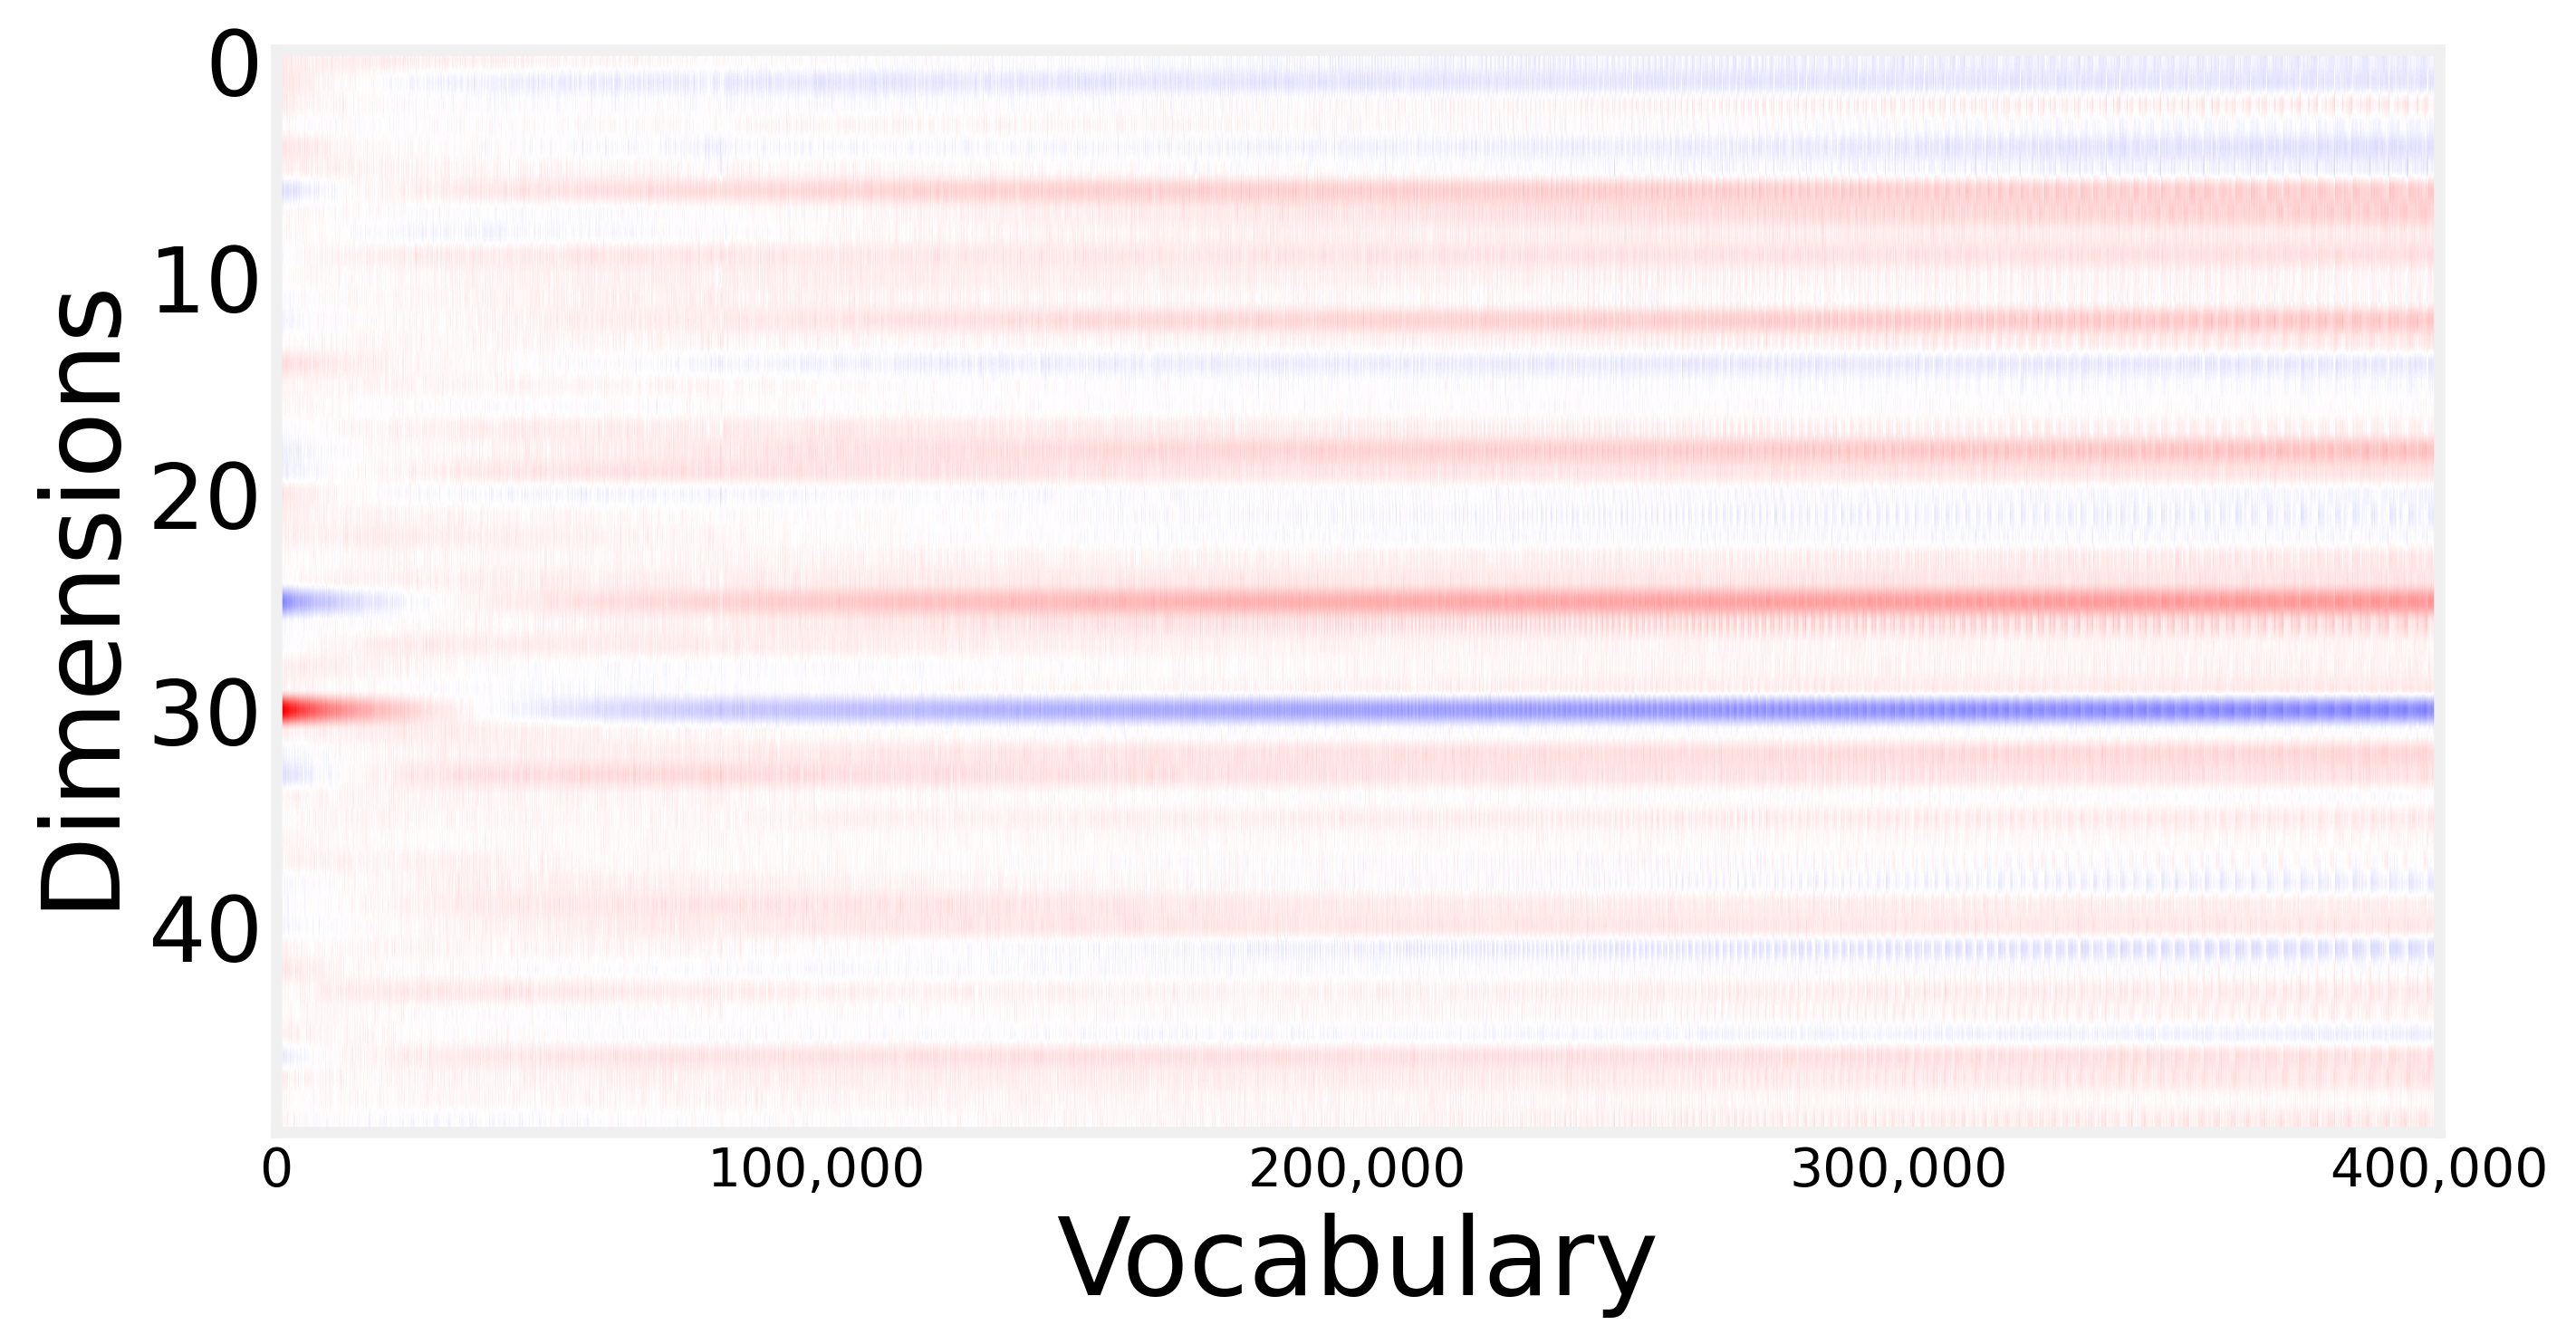

In [35]:
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(embeddings.T, aspect=4000, cmap=plt.cm.seismic)
ax.grid(None)
ax.set_xticks([0, 100000, 200000, 300000, 400000])
ax.set_xticklabels(["0", "100,000", "200,000", "300,000", "400,000"], fontsize=14)
ax.set_xlabel("Vocabulary")
ax.set_ylabel("Dimensions")

A 2D projection makes it clear that semantics is also encoded in the representation

In [36]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500 # Plot only 500 words
low_dim_embs = tsne.fit_transform(np.array(embeddings)[:plot_only, :])

In [37]:
labels = [word_list[i] for i in range(plot_only)]

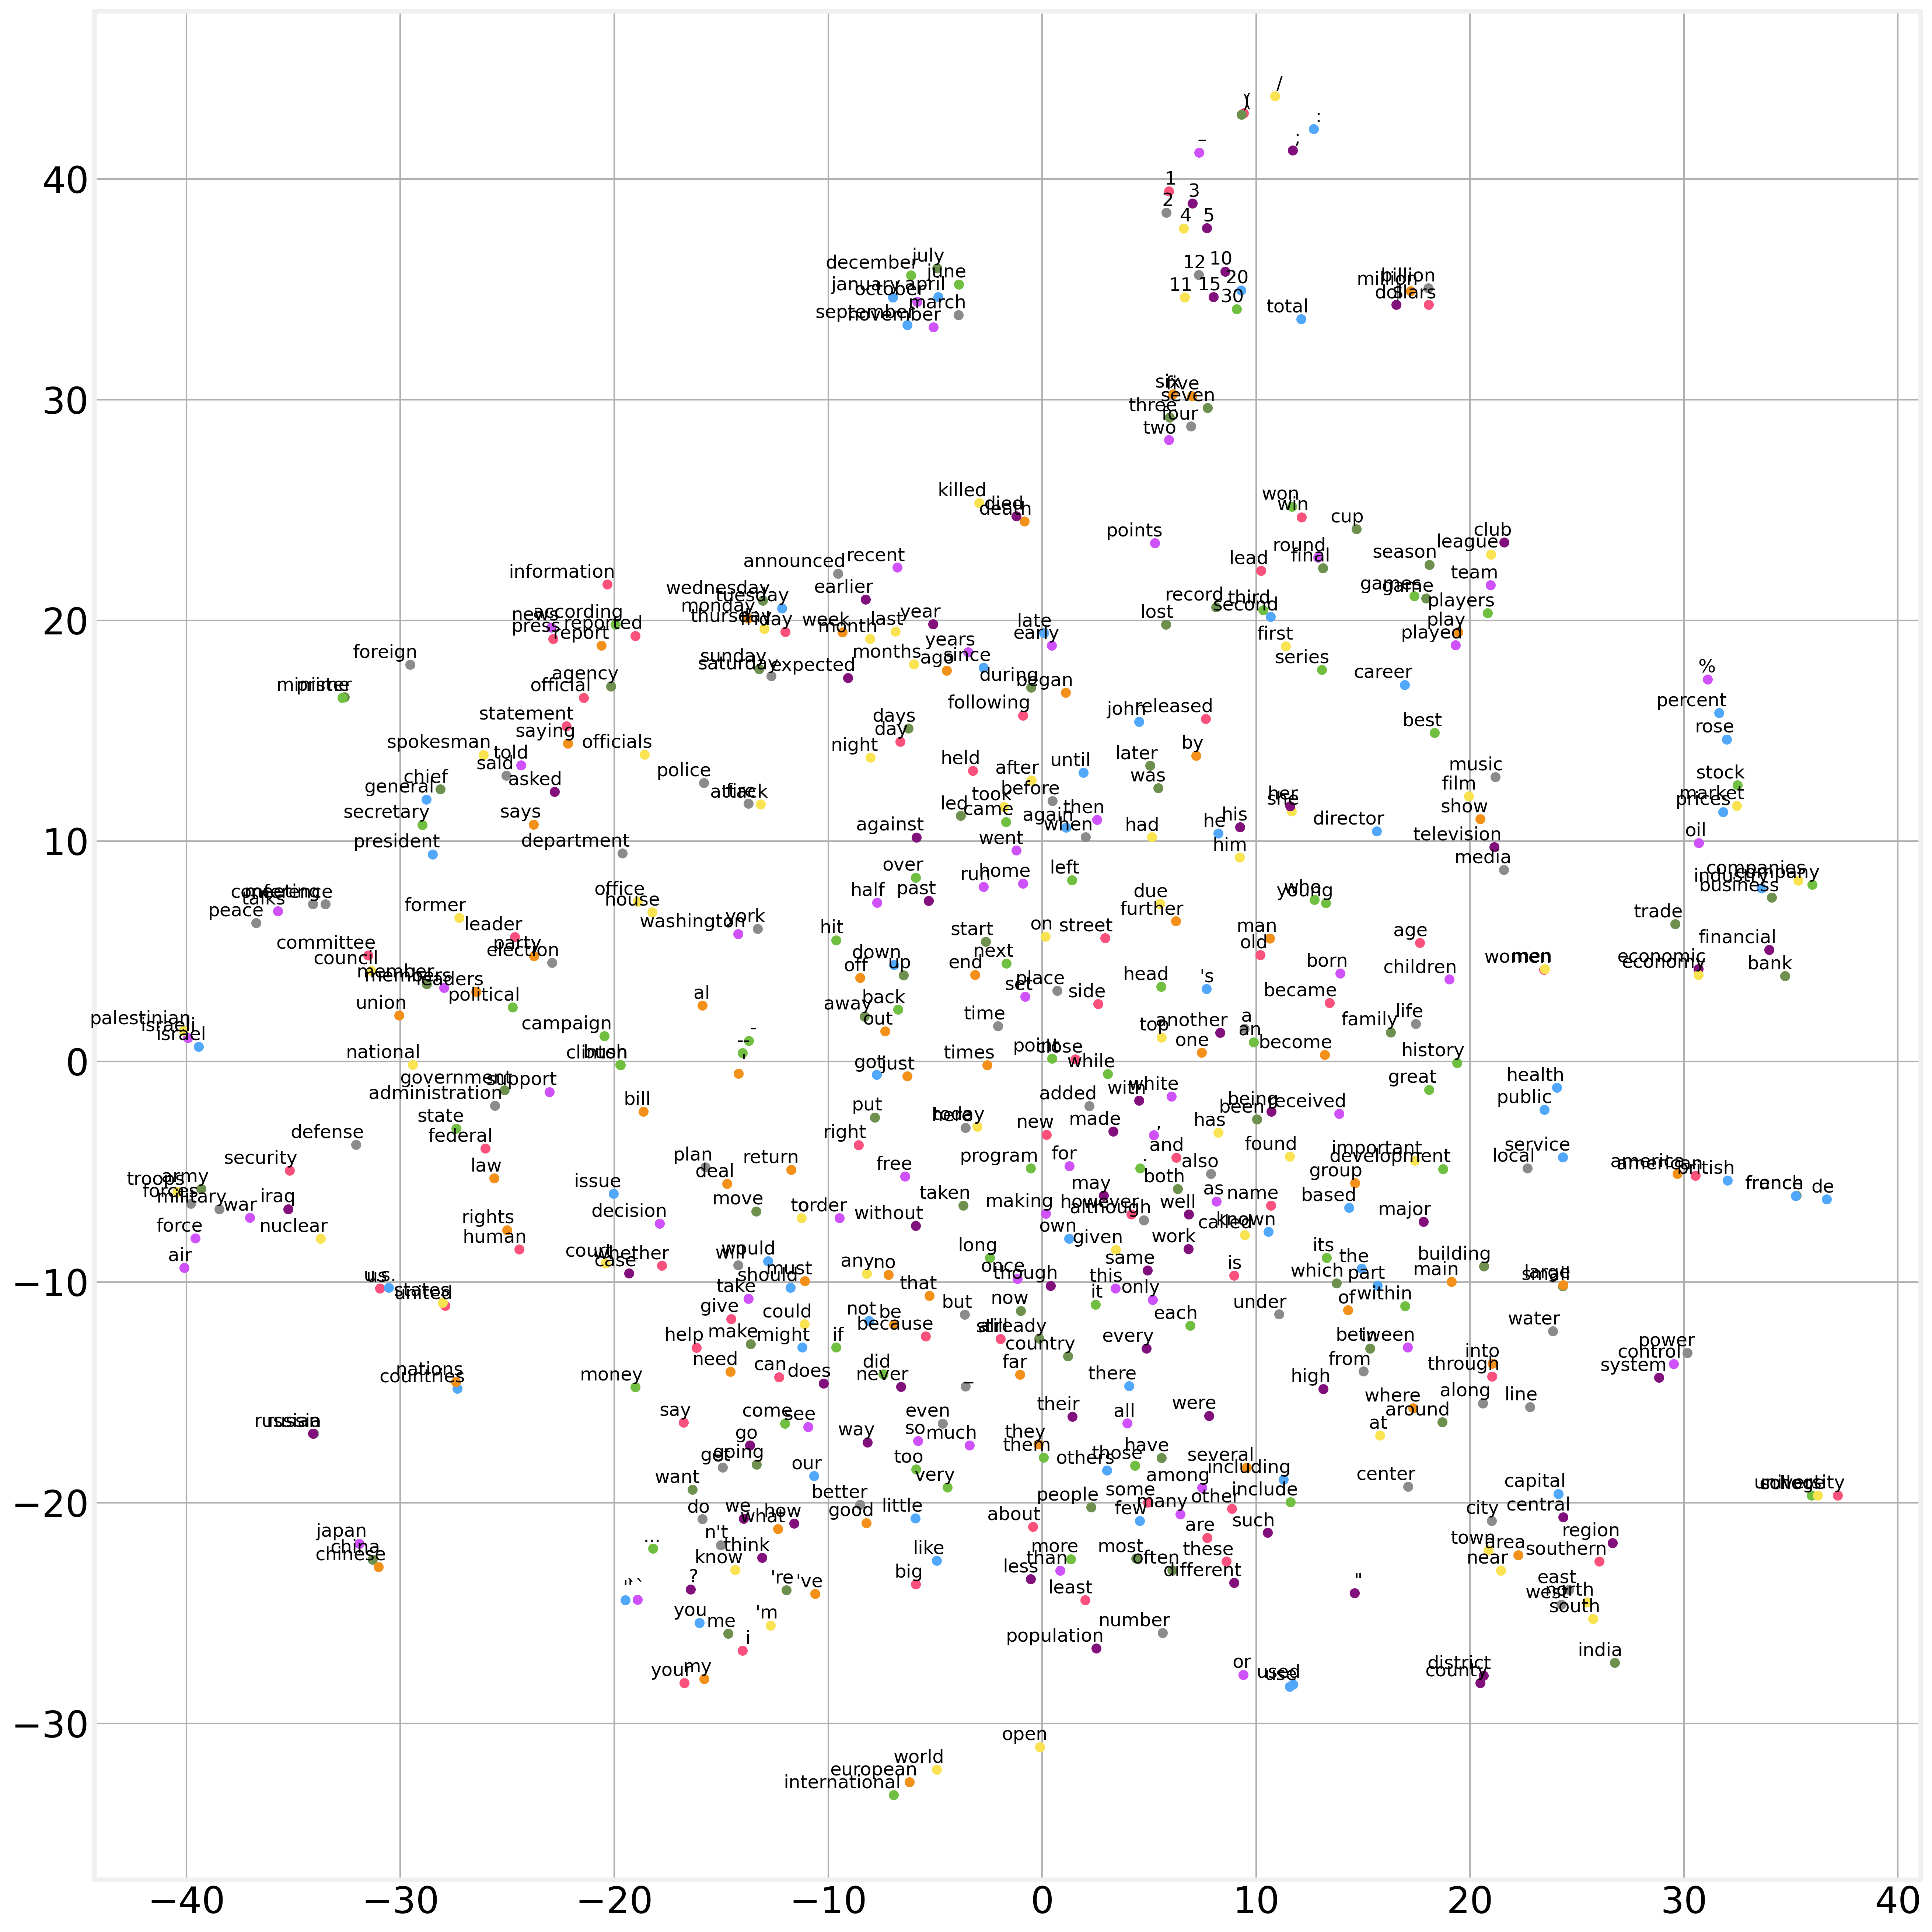

In [38]:
plt.figure(figsize=(18, 18))

for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                fontsize=12)

We can also use the cosine_similarity to verify that similar words have high similarity, while unrelated words have very low similarity

In [39]:
cosine_similarity(embeddings[word_dict['king']].reshape(1, -1), 
                  embeddings[word_dict['prince']].reshape(1, -1))

array([[0.8236179]], dtype=float32)

And naturally, unrelated words have very low similarity

In [40]:
cosine_similarity(embeddings[word_dict['blue']].reshape(1, -1), 
                  embeddings[word_dict['null']].reshape(1, -1))

array([[-0.0510289]], dtype=float32)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>